The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

1)	FRESH: annual spending (m.u.) on fresh products (Continuous)

2)	MILK: annual spending (m.u.) on milk products (Continuous)

3)	GROCERY: annual spending (m.u.) on grocery products (Continuous)

4)	FROZEN: annual spending (m.u.) on frozen products (Continuous)

5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)

6)	DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous)

7)	CHANNEL: Horeca (Hotel/Restaurant/Cafe) [1] or Retail [2] channel (Nominal)

8)	REGION: Lisbon [1] , Oporto [2] or Other [3] (Nominal)

Dataset from: M. Cardoso. "Wholesale customers," UCI Machine Learning Repository, 2013. [Online]. Available: https://doi.org/10.24432/C5030X.

In [304]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, OPTICS, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator, FixedFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Wholesale customers data.csv')

In [3]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
data.shape

(440, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [8]:
data.duplicated().sum()

0

In [15]:
clus_data = data[data.columns[2:8]]
clus_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [16]:
target = data['Region']

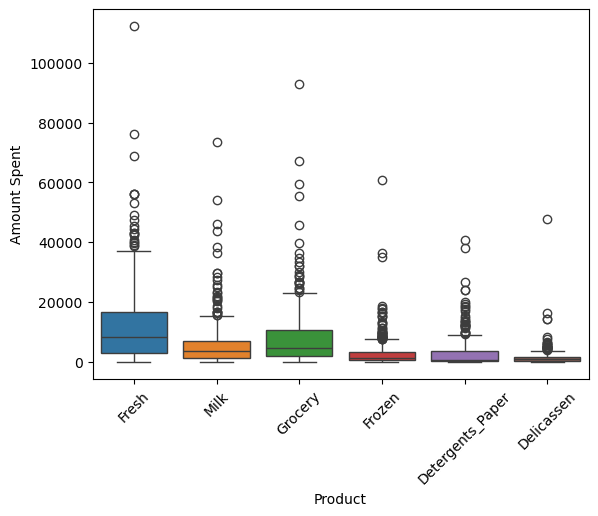

In [21]:
sns.boxplot(data=clus_data)
plt.xlabel('Product')
plt.ylabel('Amount Spent')
plt.xticks(rotation=45)
plt.show()

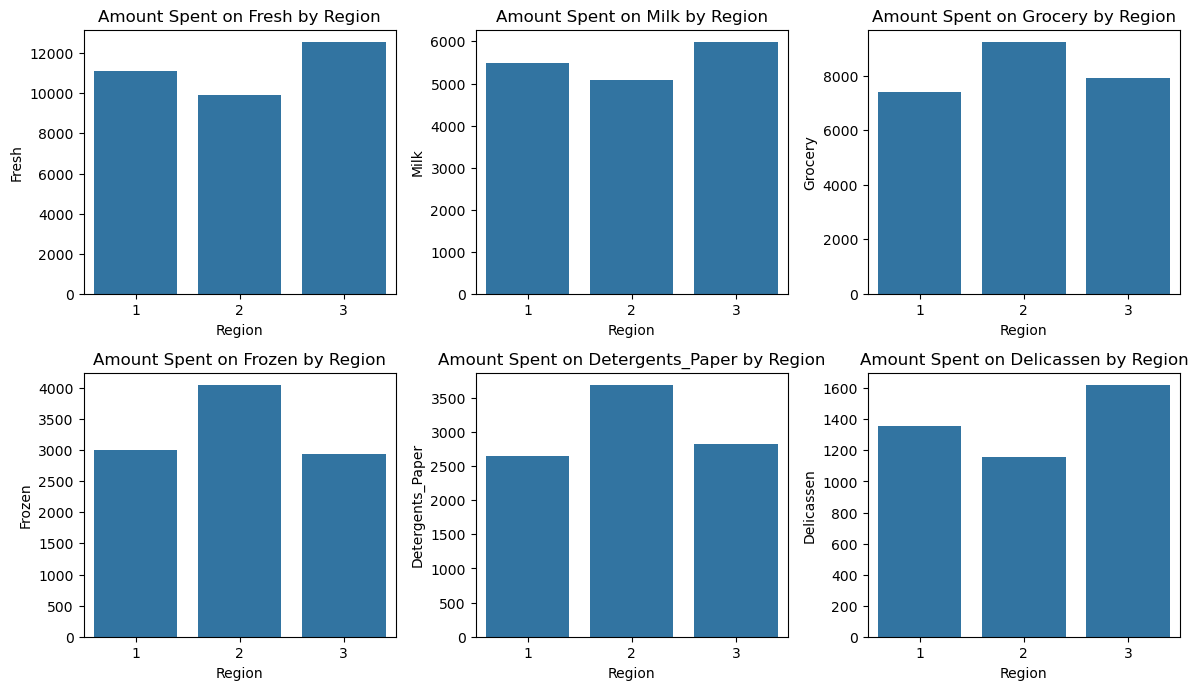

In [50]:
products = data.columns[2:8].tolist()

plt.figure(figsize=(12,10))
for i in range(len(products)):
    plt.subplot(3, 3, i+1)
    sns.barplot(x=data['Region'], y=data[products[i]], errorbar=None)
    plt.title(f'Amount Spent on {products[i]} by Region')
    plt.tight_layout()
plt.show()

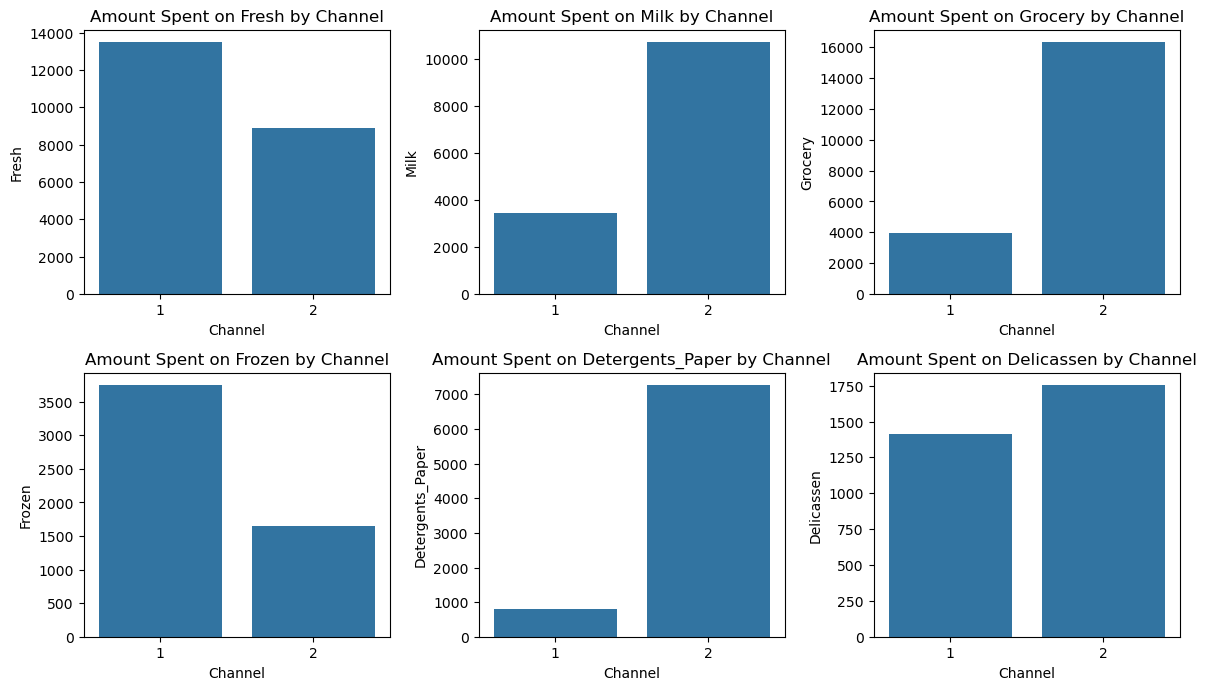

In [51]:
plt.figure(figsize=(12,10))
for i in range(len(products)):
    plt.subplot(3, 3, i+1)
    sns.barplot(x=data['Channel'], y=data[products[i]], errorbar=None)
    plt.title(f'Amount Spent on {products[i]} by Channel')
    plt.tight_layout()
plt.show()

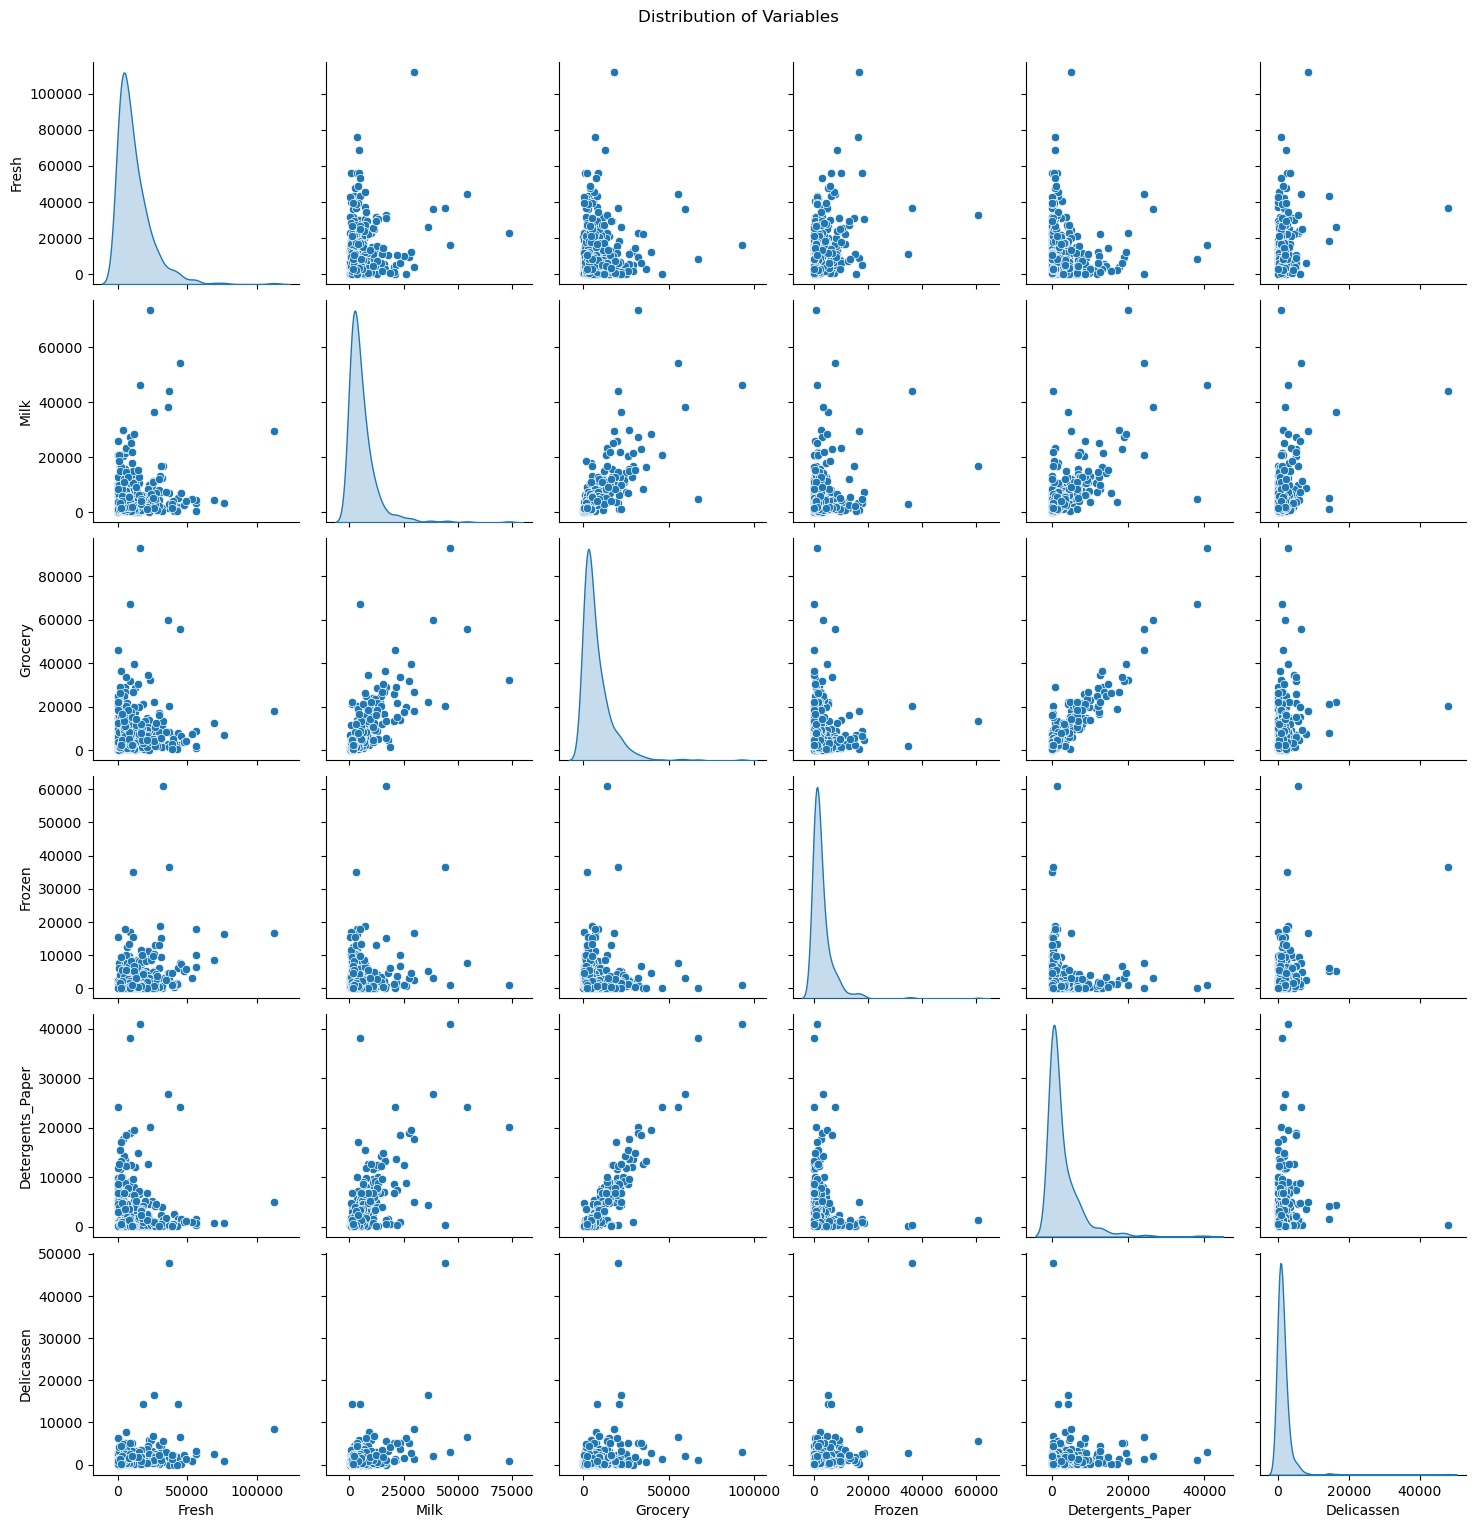

In [234]:
sns.pairplot(data=clus_data, diag_kind='kde')
plt.suptitle('Distribution of Variables', y=1.02)
plt.show()

<Axes: >

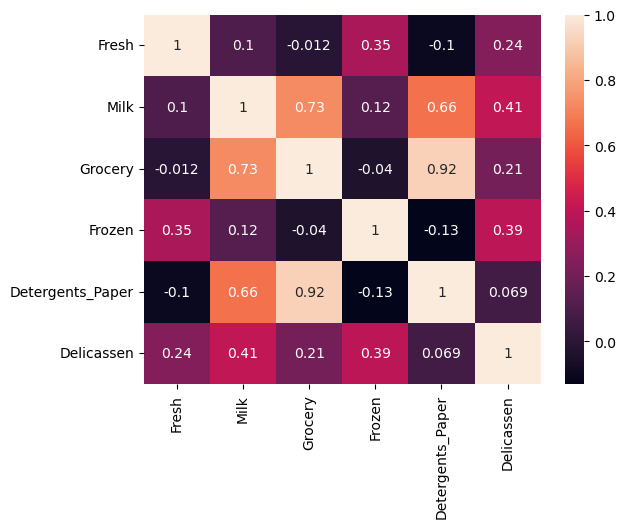

In [56]:
sns.heatmap(data=clus_data.corr(), annot=True)

### KMeans

In [338]:
scaled_data = PowerTransformer(method='box-cox').fit_transform(clus_data)

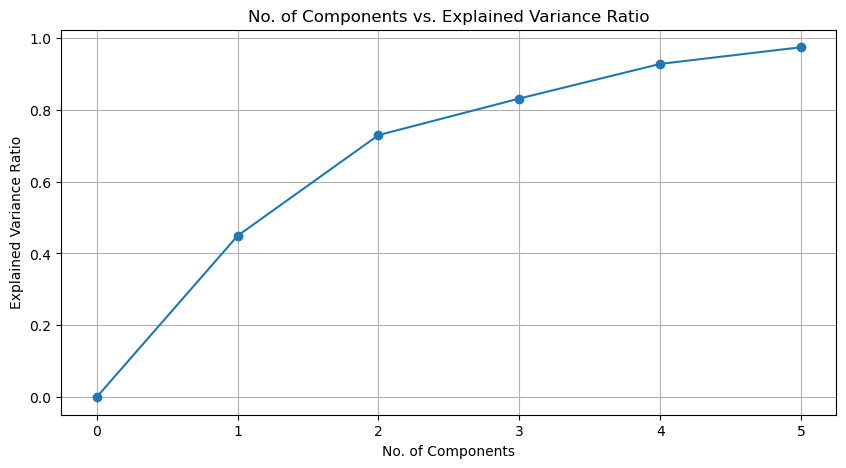

In [339]:
nums = np.arange(6)

var_ratio = []

for num in nums:
    pca = PCA(n_components=num)
    pca.fit(scaled_data)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nums, var_ratio, marker='o')
plt.xlabel('No. of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('No. of Components vs. Explained Variance Ratio')
plt.show()

In [340]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(scaled_data)

In [342]:
reduced_df = pd.DataFrame(data_reduced, index=data.index, columns=['PC1', 'PC2'])
reduced_df.head()

,PC1,PC2
0,1.313524,-0.402012
1,1.451733,0.326216
2,1.666275,1.263738
3,-0.855733,1.211462
4,0.854660,1.960276


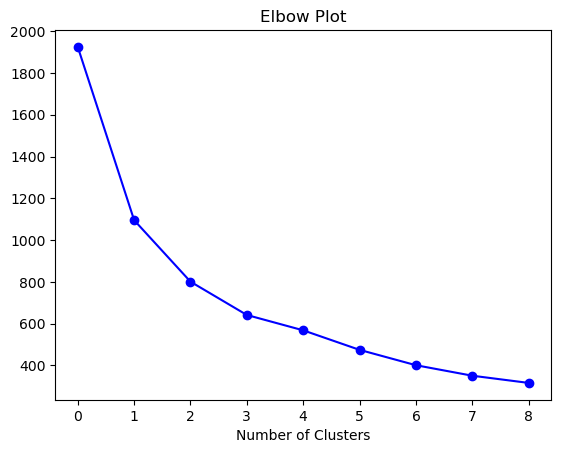

In [343]:
wcss = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(reduced_df)
    wcss.append(kmeans.inertia_)

plt.plot(wcss, "bo-")
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.show()

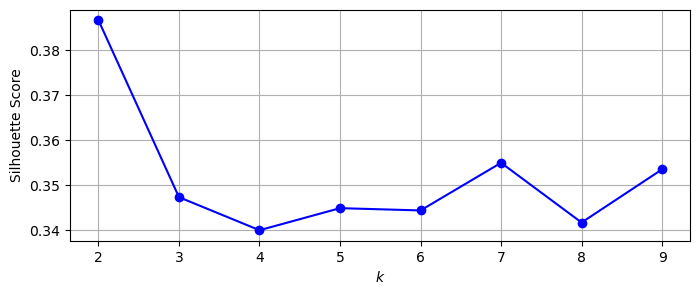

In [344]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(reduced_df)
               for k in range(2, 11)]

silhouette_scores = [silhouette_score(reduced_df, model.labels_)
                    for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

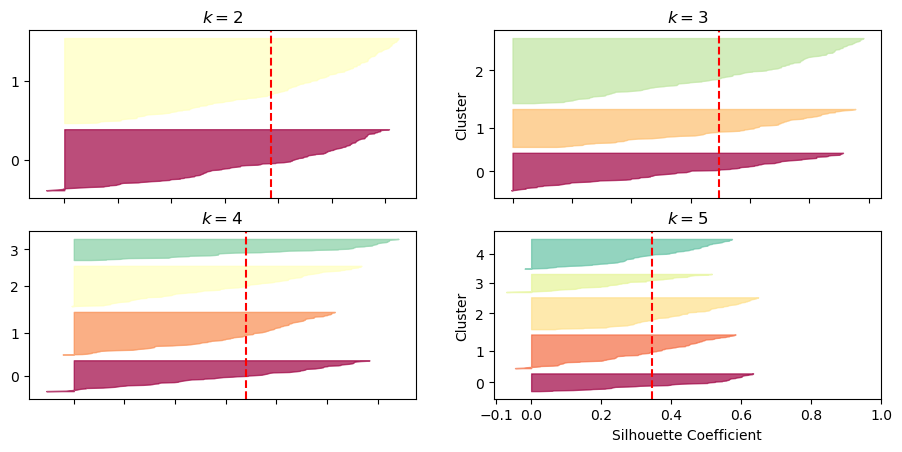

In [345]:
plt.figure(figsize=(11, 10))

for k in (2, 3, 4, 5):
    plt.subplot(4, 2, k - 1)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(reduced_df, y_pred)

    padding = len(reduced_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

In [346]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels_km = kmeans.fit_predict(reduced_df)
data['Cluster_KMeans'] = cluster_labels_km
reduced_df['Cluster_KMeans'] = cluster_labels_km

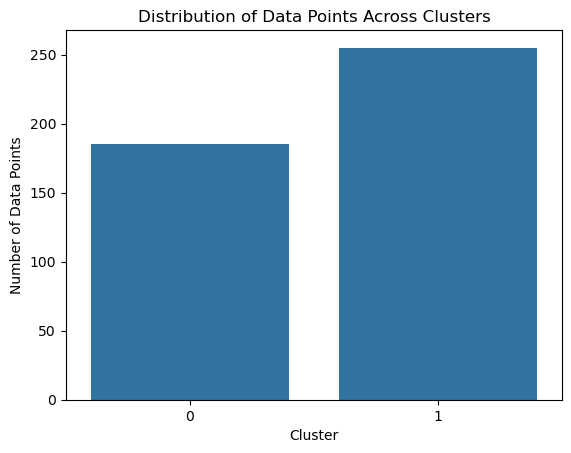

In [347]:
sns.countplot(data=data, x='Cluster_KMeans')
plt.title('Distribution of Data Points Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()

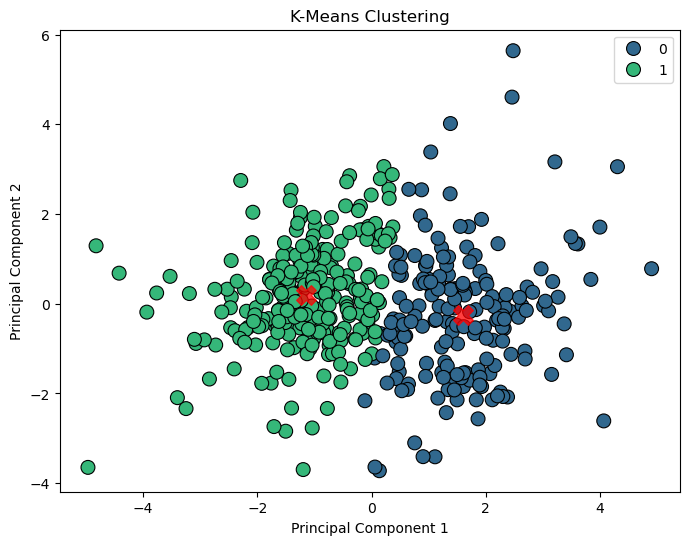

In [349]:
centres_reduced = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x=reduced_df['PC1'], y=reduced_df['PC2'], hue=cluster_labels_km, palette="viridis", s=100, edgecolor='k', marker='o')
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [351]:
print(f"Silhouette Coefficient: {silhouette_score(reduced_df, cluster_labels_km):.3f}")

Silhouette Coefficient: 0.447


### DBSCAN

In [368]:
db = DBSCAN(eps=0.5, min_samples=7).fit(reduced_df)
data['Cluster_DBSCAN'] = db.labels_

In [369]:
reduced_df['Cluster_DBSCAN'] = db.labels_
reduced_df.head()

,PC1,PC2,Cluster_KMeans,Cluster_DBSCAN
0,1.313524,-0.402012,0,0
1,1.451733,0.326216,0,0
2,1.666275,1.263738,0,0
3,-0.855733,1.211462,1,1
4,0.854660,1.960276,0,-1


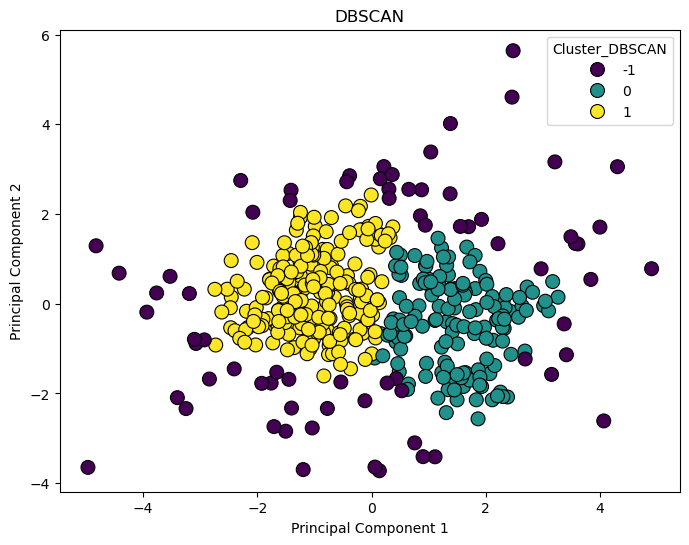

In [370]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x=reduced_df['PC1'], y=reduced_df['PC2'], hue='Cluster_DBSCAN', palette="viridis", s=100, edgecolor='k', marker='o')
plt.title("DBSCAN")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [371]:
print(f"Silhouette Coefficient: {silhouette_score(reduced_df, db.labels_):.3f}")

Silhouette Coefficient: 0.416


### MeanShift

In [392]:
bandwidth = estimate_bandwidth(reduced_df)
ms = MeanShift(bandwidth=bandwidth).fit(reduced_df)
labels = ms.labels_
data['Cluster_MeanShift'] = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 4


In [393]:
reduced_df['Cluster_MeanShift'] = ms.labels_
reduced_df.head()

,PC1,PC2,Cluster_KMeans,Cluster_DBSCAN,Cluster_MeanShift,Cluster_Agglomerative
0,1.313524,-0.402012,0,0,1,1
1,1.451733,0.326216,0,0,1,1
2,1.666275,1.263738,0,0,1,1
3,-0.855733,1.211462,1,1,0,0
4,0.854660,1.960276,0,-1,1,1


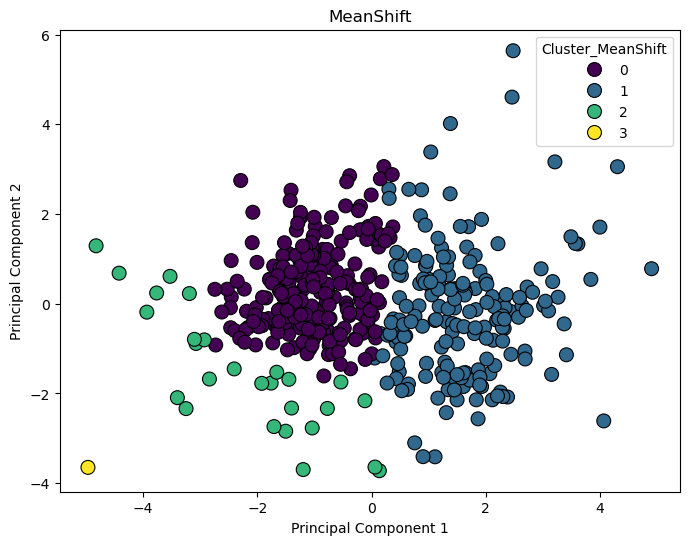

In [394]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x=reduced_df['PC1'], y=reduced_df['PC2'], hue='Cluster_MeanShift', palette="viridis", s=100, edgecolor='k', marker='o')
plt.title("MeanShift")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [395]:
print(f"Silhouette Coefficient: {silhouette_score(reduced_df, ms.labels_):.3f}")

Silhouette Coefficient: 0.505


### Agglomerative Clustering

In [377]:
agg = AgglomerativeClustering()
agg_clusters = agg.fit_predict(reduced_df)
data['Cluster_Agglomerative'] = agg_clusters

In [378]:
reduced_df['Cluster_Agglomerative'] = agg_clusters
reduced_df.head()

,PC1,PC2,Cluster_KMeans,Cluster_DBSCAN,Cluster_MeanShift,Cluster_Agglomerative
0,1.313524,-0.402012,0,0,1,1
1,1.451733,0.326216,0,0,1,1
2,1.666275,1.263738,0,0,1,1
3,-0.855733,1.211462,1,1,0,0
4,0.854660,1.960276,0,-1,1,1


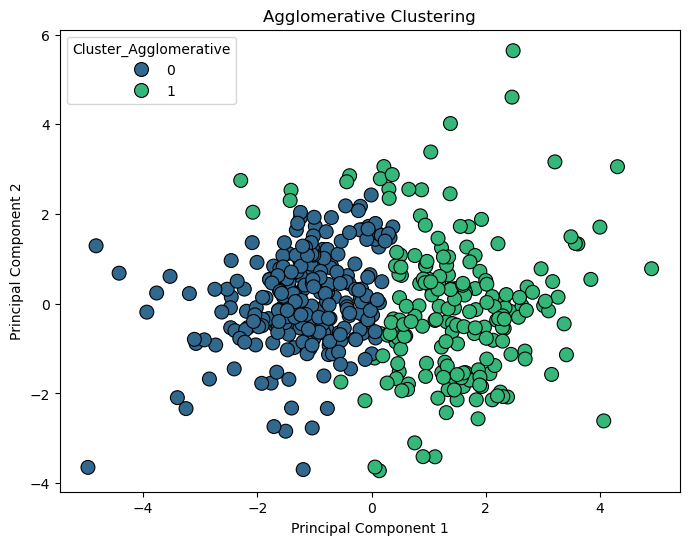

In [379]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x=reduced_df['PC1'], y=reduced_df['PC2'], hue='Cluster_Agglomerative', palette="viridis", s=100, edgecolor='k', marker='o')
plt.title("Agglomerative Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [380]:
print(f"Silhouette Coefficient: {silhouette_score(reduced_df, agg_clusters):.3f}")

Silhouette Coefficient: 0.468
